### Cab-Driver Agent

In [3]:
# Importing libraries
import numpy as np
import random
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [5]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [6]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001

        # defining epsilon
        self.epsilon = 1
        self.epsilon_decay = 0.09
        self.epsilon_min = 0.0001

        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Adding layers to your neural nets   
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def get_action(self, state, action_space):
        """
        get action from model using epsilon-greedy policy
        Decay in ε after we generate each sample from the environment
        """

        if np.random.rand() <= self.epsilon:
            
            possible_actions_index, actions = env.requests(state)

            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action
        else:
            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            selected_q_value = np.argmax(q_value[0])
            return selected_q_value, action_space[selected_q_value]

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """

        if len(self.memory) > self.batch_size:

            # Sample minibatch from the memory
            minibatch = random.sample(self.memory, self.batch_size)

            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size))  # write here

            actions, rewards = [], []

            for i in range(self.batch_size):
                state, action, reward, next_state = minibatch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state

                # Write your code from here
                # 1. Predict the target from earlier model
                target = self.model.predict(update_input)

                # 2. Get the target for the Q-network
                target_qval = self.model.predict(update_output)

                # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def store_q_values(self):
        """ We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])
            
    def save(self, name):
        self.model.save(name)
    

In [9]:
Episodes = 100

### DQN block

In [10]:
start_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

# creating environment
env = CabDriver()

# creating agent and using architecture 1
agent = DQNAgent(
    action_size=len(env.action_space),
    state_size=len(env.state_encod_arch1(env.state_init))
)

#### simulation starts ####
for episode in range(Episodes):

    # Call the environment
    # env = CabDriver()

    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()

    terminal_state = False
    score = 0
    total_time = 0

    while not terminal_state:
        
        # Write your code here
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space)
        
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action, Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)

        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action_index, reward, env.state_encod_arch1(next_state))

        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        total_time += wait_time + transit_time + ride_time
        
        if total_time >= 24 * 30:
            print("state terminated")
            terminal_state = True

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every episode:
    print(f"episode {episode}, reward {score}, epsilon {agent.epsilon}")

    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    
    if episode % 1000 == 0:
        agent.save(name="cab_driver.pkl")

elapsed_time = time.time() - start_time
print('Total time taken: ', elapsed_time)

state terminated
episode 0, reward -206.0, epsilon 1.0
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cab_driver.pkl/assets
state terminated
episode 1, reward -549.0, epsilon 0.913939792152701
state terminated
episode 2, reward -303.0, epsilon 0.7634031563874195
state terminated
episode 3, reward -213.0, epsilon 0.5827899775487523
state terminated
episode 4, reward 50.0, epsilon 0.40662900277462505
state terminated
episode 5, reward 395.0, epsilon 0.25931433661982695
state terminated
episode 6, reward 382.0, epsilon 0.15115670165548722
state terminated
episode 7, reward 938.0, epsilon 0.0805515607888575
state terminated
episode 8, reward 2038.0, epsilon 0.039259978709477186
state terminated
episode 9, reward 2524.0, epsilon 0.017520632402029567
state terminated
episod

In [18]:
save_obj(rewards_per_episode, "rewards_per_episode")

### Tracking Convergence

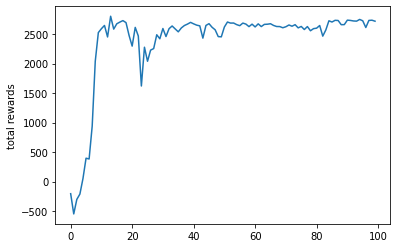

In [11]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [12]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[2387.57]


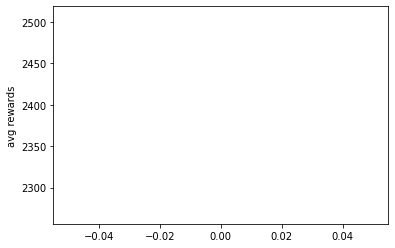

In [13]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

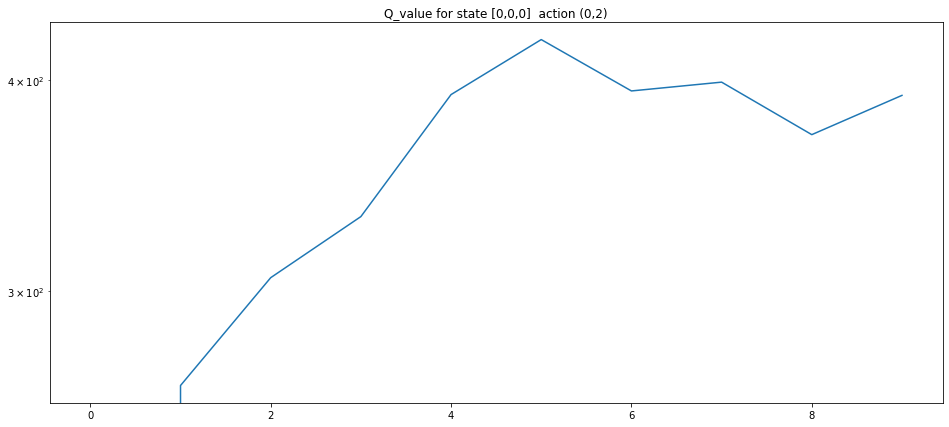

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [15]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

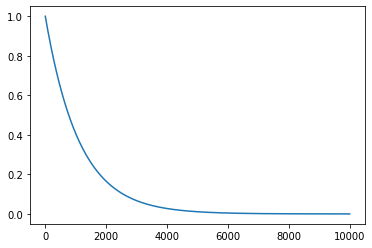

In [16]:
plt.plot(time, epsilon)
plt.show()